selected features: 672
preprocess done

Training with n_hidden=4, lambdaval=0
Validation Accuracy: 73.28%, Training Time: 19.364940404891968 sec

Training with n_hidden=4, lambdaval=10
Validation Accuracy: 46.28%, Training Time: 18.961107969284058 sec

Training with n_hidden=4, lambdaval=20
Validation Accuracy: 78.82000000000001%, Training Time: 14.274726867675781 sec

Training with n_hidden=4, lambdaval=30
Validation Accuracy: 73.07000000000001%, Training Time: 15.924467086791992 sec

Training with n_hidden=4, lambdaval=40
Validation Accuracy: 81.46%, Training Time: 15.203231573104858 sec

Training with n_hidden=4, lambdaval=50
Validation Accuracy: 67.65%, Training Time: 17.706502437591553 sec

Training with n_hidden=4, lambdaval=60
Validation Accuracy: 44.71%, Training Time: 20.699461698532104 sec

Training with n_hidden=8, lambdaval=0
Validation Accuracy: 88.16000000000001%, Training Time: 25.988171100616455 sec

Training with n_hidden=8, lambdaval=10
Validation Accuracy: 75.73%, Tr

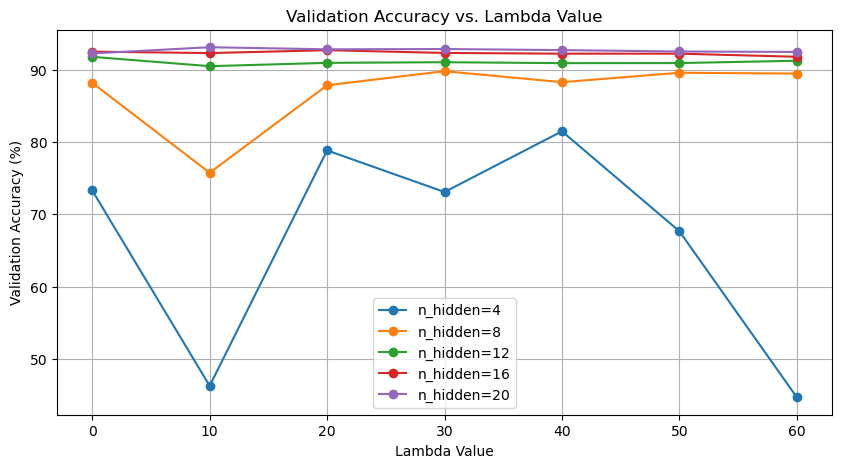

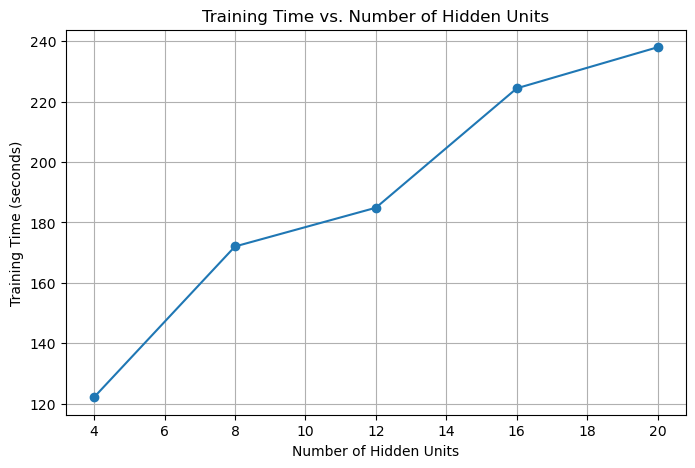

 Best Hyperparameters:
   n_hidden: 20
   lambdaval: 10
   validation accuracy: 93.08

 Training set Accuracy:93.432%

 Validation set Accuracy:93.08999999999999%

 Test set Accuracy: 93.27%

 lambda: 10 

 n_hidden: 20 


 w1: [[ 0.02110909  0.01559514 -0.03631879 ...  0.02583094 -0.06970125
  -0.16685513]
 [-0.03877773 -0.01917363 -0.06120885 ... -0.05265144 -0.01963644
   0.05526112]
 [-0.04982456  0.05337897 -0.06057174 ... -0.01391883 -0.00160793
  -0.71043052]
 ...
 [-0.02353524  0.06538783 -0.01597    ... -0.01102012  0.0506039
  -0.37061924]
 [ 0.01843285  0.01740928 -0.02395655 ... -0.00175643 -0.03405185
  -0.04691093]
 [ 0.06705635 -0.05403844 -0.04119787 ... -0.04908105 -0.03162261
   0.2778965 ]] 


 w2: [[ 1.13529868  1.38104317  1.30712641 -0.77624262 -1.84860857  0.10270704
  -1.87034434  0.82004146 -1.17088639 -0.76592347 -1.98894916 -2.81878854
  -0.1991916   1.92501679 -1.72603452 -1.25477205  1.43735454 -0.93703284
  -0.03315119 -3.63835161 -1.24516965]
 [ 0.6244752

In [1]:
import time
import json
import pickle
import numpy as np
from scipy.optimize import minimize
from scipy.io import loadmat
from math import sqrt
import matplotlib.pyplot as plt
import os



def initializeWeights(n_in, n_out):
    """
    # initializeWeights return the random weights for Neural Network given the
    # number of node in the input layer and output layer

    # Input:
    # n_in: number of nodes of the input layer
    # n_out: number of nodes of the output layer
       
    # Output: 
    # W: matrix of random initial weights with size (n_out x (n_in + 1))"""

    epsilon = sqrt(6) / sqrt(n_in + n_out + 1)
    W = (np.random.rand(n_out, n_in + 1) * 2 * epsilon) - epsilon
    return W
    
def sigmoid(z):    
    """Notice that z can be a scalar, a vector or a matrix
    # return the sigmoid of input z"""

    return  1 / (1 + np.exp(-z))


def preprocess():
    """ Input:
     Although this function doesn't have any input, you are required to load
     the MNIST data set from file 'mnist_all.mat'.

     Output:
     train_data: matrix of training set. Each row of train_data contains 
       feature vector of a image
     train_label: vector of label corresponding to each image in the training
       set
     validation_data: matrix of training set. Each row of validation_data 
       contains feature vector of a image
     validation_label: vector of label corresponding to each image in the 
       training set
     test_data: matrix of training set. Each row of test_data contains 
       feature vector of a image
     test_label: vector of label corresponding to each image in the testing
       set
    """

    mat = loadmat("C:/Users/ankit/OneDrive/Desktop/my_projects/digit classification/mnist_all.mat")  # loads the MAT object as a Dictionary

    # Split the training sets into two sets of 50000 randomly sampled training examples and 10000 validation examples. 

    train_data = []
    train_label = []
    test_data = []
    test_label = []

    for i in range(10):  
        train_data.append(mat[f'train{i}'])  
        train_label.append(np.full((mat[f'train{i}'].shape[0], 1), i))  

        test_data.append(mat[f'test{i}'])  
        test_label.append(np.full((mat[f'test{i}'].shape[0], 1), i))  

    train_data = np.vstack(train_data)
    train_label = np.vstack(train_label).flatten()
    test_data = np.vstack(test_data)
    test_label = np.vstack(test_label).flatten()

    train_data = train_data.astype(np.float32) / 255.0
    test_data = test_data.astype(np.float32) / 255.0

    indices = np.arange(train_data.shape[0])
    np.random.shuffle(indices)

    train_data, validation_data = train_data[indices[:50000]], train_data[indices[50000:]]
    train_label, validation_label = train_label[indices[:50000]], train_label[indices[50000:]]

    # Feature selection

    feature_var = np.var(train_data, axis=0)  
    selected_features = np.where(feature_var > 1e-5)[0]  

    train_data = train_data[:, selected_features]
    validation_data = validation_data[:, selected_features]
    test_data = test_data[:, selected_features]

    print("selected features:", len(selected_features))
    print('preprocess done')

    return train_data, train_label, validation_data, validation_label, test_data, test_label, selected_features


def nnObjFunction(params, *args):
    """% nnObjFunction computes the value of objective function (negative log 
    %   likelihood error function with regularization) given the parameters 
    %   of Neural Networks, thetraining data, their corresponding training 
    %   labels and lambda - regularization hyper-parameter.

    % Input:
    % params: vector of weights of 2 matrices w1 (weights of connections from
    %     input layer to hidden layer) and w2 (weights of connections from
    %     hidden layer to output layer) where all of the weights are contained
    %     in a single vector.
    % n_input: number of node in input layer (not include the bias node)
    % n_hidden: number of node in hidden layer (not include the bias node)
    % n_class: number of node in output layer (number of classes in
    %     classification problem
    % training_data: matrix of training data. Each row of this matrix
    %     represents the feature vector of a particular image
    % training_label: the vector of truth label of training images. Each entry
    %     in the vector represents the truth label of its corresponding image.
    % lambda: regularization hyper-parameter. This value is used for fixing the
    %     overfitting problem.
       
    % Output: 
    % obj_val: a scalar value representing value of error function
    % obj_grad: a SINGLE vector of gradient value of error function
    % NOTE: how to compute obj_grad
    % Use backpropagation algorithm to compute the gradient of error function
    % for each weights in weight matrices.

    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    % reshape 'params' vector into 2 matrices of weight w1 and w2
    % w1: matrix of weights of connections from input layer to hidden layers.
    %     w1(i, j) represents the weight of connection from unit j in input 
    %     layer to unit i in hidden layer.
    % w2: matrix of weights of connections from hidden layer to output layers.
    %     w2(i, j) represents the weight of connection from unit j in hidden 
    %     layer to unit i in output layer."""

    n_input, n_hidden, n_class, training_data, training_label, lambdaval = args

    w1 = params[0:n_hidden * (n_input + 1)].reshape((n_hidden, (n_input + 1)))
    w2 = params[(n_hidden * (n_input + 1)):].reshape((n_class, (n_hidden + 1)))
    obj_val = 0
   
    # Make sure you reshape the gradient matrices to a 1D array. for instance if your gradient matrices are grad_w1 and grad_w2
    # you would use code similar to the one below to create a flat array
    # obj_grad = np.concatenate((grad_w1.flatten(), grad_w2.flatten()),0)
    #obj_grad = np.array([])

    # forward_propagation
   
    bias = np.ones((training_data.shape[0], 1))
    training_data = np.hstack((training_data, bias))  
    
    hidden_input = np.dot(training_data, w1.T)
    hidden_output = sigmoid(hidden_input)
    hidden_output = np.hstack((hidden_output, np.ones((hidden_output.shape[0], 1))))  
    
    output_input = np.dot(hidden_output, w2.T)
    output_output = sigmoid(output_input)
    
    y = np.zeros((train_label.shape[0], n_class))
    y[np.arange(train_label.shape[0]), train_label] = 1
    
    # Computing Error using negative Log likelihood
    
    error = -np.sum(y * np.log(output_output) + (1 - y) * np.log(1 - output_output)) / training_data.shape[0]
    
    reg_term = (lambdaval / (2 * training_data.shape[0])) * (np.sum(w1 ** 2) + np.sum(w2 ** 2))
    
    obj_val = error + reg_term
    
    # backpropagation
   
    delta_output = output_output - y
    delta_hidden = np.dot(delta_output, w2) * hidden_output * (1 - hidden_output)
    
    delta_hidden = delta_hidden[:, :-1]
    
    grad_w1 = (np.dot(delta_hidden.T, training_data) + lambdaval * w1) / training_data.shape[0]
    grad_w2 = (np.dot(delta_output.T, hidden_output) + lambdaval * w2) / training_data.shape[0]
    
    obj_grad = np.concatenate((grad_w1.flatten(), grad_w2.flatten()), 0)
    
    return (obj_val, obj_grad)

def tune_hyperparameters(train_data, train_label, validation_data, validation_label):
    
    n_input = train_data.shape[1]
    n_class = 10  

    lambdaval_range = list(range(0, 65, 10))  
    n_hidden_range = [4, 8, 12, 16, 20]

    best_accuracy = 0
    best_lambdaval = 0
    best_n_hidden = 0

    accuracy_results = {}  
    training_times = {}  

    for n_hidden in n_hidden_range:
        accuracy_results[n_hidden] = []
        total_start_time = time.time()  

        for lambdaval in lambdaval_range:
            print(f"\nTraining with n_hidden={n_hidden}, lambdaval={lambdaval}")
            
            iteration_start_time = time.time()  

            initial_w1 = initializeWeights(n_input, n_hidden)
            initial_w2 = initializeWeights(n_hidden, n_class)
            initialWeights = np.concatenate((initial_w1.flatten(), initial_w2.flatten()), 0)

            args = (n_input, n_hidden, n_class, train_data, train_label, lambdaval)
            opts = {'maxiter': 50}

            nn_params = minimize(nnObjFunction, initialWeights, jac=True, args=args, method='CG', options=opts)
            w1 = nn_params.x[0:n_hidden * (n_input + 1)].reshape((n_hidden, (n_input + 1)))
            w2 = nn_params.x[(n_hidden * (n_input + 1)):].reshape((n_class, (n_hidden + 1)))
            predicted_label = nnPredict(w1, w2, validation_data)
            accuracy = 100 * np.mean((predicted_label == validation_label).astype(float))
            accuracy_results[n_hidden].append(accuracy)

            iteration_time = time.time() - iteration_start_time  
            print("Validation Accuracy: "+str(accuracy)+ "%, Training Time: "+str(iteration_time) +" sec")


            if accuracy > best_accuracy:
                best_accuracy =accuracy
                best_lambdaval= lambdaval
                best_n_hidden=n_hidden

        training_times[n_hidden]=time.time()- total_start_time

    plt.figure(figsize=(10, 5))
    for n_hidden, accuracies in accuracy_results.items():
        plt.plot(lambdaval_range, accuracies, marker='o', label=f'n_hidden={n_hidden}')
    
    plt.xlabel('Lambda Value')
    plt.ylabel('Validation Accuracy (%)')
    plt.title('Validation Accuracy vs. Lambda Value')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.plot(n_hidden_range, [training_times[n] for n in n_hidden_range], marker='o', linestyle='-')
    plt.xlabel('Number of Hidden Units')
    plt.ylabel('Training Time (seconds)')
    plt.title('Training Time vs. Number of Hidden Units')
    plt.grid(True)
    plt.show()

    print(" Best Hyperparameters:")
    print("   n_hidden:" , best_n_hidden)
    print("   lambdaval:" , best_lambdaval)
    print('   validation accuracy:' , best_accuracy)
    return best_lambdaval, best_n_hidden, n_class


def nnPredict(w1, w2, data):
    """% nnPredict predicts the label of data given the parameter w1, w2 of Neural
    % Network.

    % Input:
    % w1: matrix of weights of connections from input layer to hidden layers.
    %     w1(i, j) represents the weight of connection from unit i in input 
    %     layer to unit j in hidden layer.
    % w2: matrix of weights of connections from hidden layer to output layers.
    %     w2(i, j) represents the weight of connection from unit i in input 
    %     layer to unit j in hidden layer.
    % data: matrix of data. Each row of this matrix represents the feature 
    %       vector of a particular image
       
    % Output: 
    % label: a column vector of predicted labels"""

    labels = np.array([])

    bias = np.ones((data.shape[0], 1))

    data = np.hstack((data, bias))
    
    hidden_input = np.dot(data, w1.T)
    hidden_output = sigmoid(hidden_input)
    hidden_output = np.hstack((hidden_output, np.ones((hidden_output.shape[0], 1))))
    output_input=np.dot(hidden_output, w2.T)
    output_output =sigmoid(output_input)

    
    labels = np.argmax(output_output, axis=1)

    return labels



def save_params_to_pickle(selected_features, n_hidden, w1, w2, lambdaval, filename="params.pickle"):
    
    # To create & save params.pickle(that stores parameters) the file we create a dictionary
    
    params = {
        'selected_features': selected_features,
        'n_hidden': n_hidden,
        'w1': w1,
        'w2': w2,
        'lambdaval': lambdaval
    }
    
    with open(filename, 'wb') as f:
        pickle.dump(params, f)
    
def save_results_to_json(model_name, training_time, test_accuracy, filename="facenn_results.json"):

    # To create & save the results of the model into a json file
    
    results = {
        "model": model_name,
        "training_time": training_time,
        "test_accuracy": test_accuracy
    }
    with open(filename, "w") as f:
        json.dump(results, f)

"""**************Neural Network Script Starts here********************************"""
if __name__ == "__main__":
    
        
    train_data, train_label, validation_data, validation_label, test_data, test_label, selected_features = preprocess()

    #  Train Neural Network
    best_lambdaval, best_n_hidden, best_n_class = tune_hyperparameters(train_data, train_label, validation_data, validation_label)


    # set the number of nodes in input unit (not including bias unit)
    n_input = train_data.shape[1]

    # set the number of nodes in hidden unit (not including bias unit)
    n_hidden = best_n_hidden

    # set the number of nodes in output unit
    n_class = 10

    # initialize the weights into some random matrices
    initial_w1 = initializeWeights(n_input, n_hidden)
    initial_w2 = initializeWeights(n_hidden, n_class)

    # unroll 2 weight matrices into single column vector
    initialWeights = np.concatenate((initial_w1.flatten(), initial_w2.flatten()), 0)

    # set the regularization hyper-parameter
    lambdaval = best_lambdaval

    args = (n_input, n_hidden, n_class, train_data, train_label, lambdaval)

    # Train Neural Network using fmin_cg or minimize from scipy,optimize module. Check documentation for a working example

    opts = {'maxiter': 50}  # Preferred value.

    train_start_time = time.time()
    nn_params = minimize(nnObjFunction, initialWeights, jac=True, args=args, method='CG', options=opts)
    training_time = time.time() - train_start_time
    
    # In Case you want to use fmin_cg, you may have to split the nnObjectFunction to two functions nnObjFunctionVal
    # and nnObjGradient. Check documentation for this function before you proceed.
    # nn_params, cost = fmin_cg(nnObjFunctionVal, initialWeights, nnObjGradient,args = args, maxiter = 50)


    # Reshape nnParams from 1D vector into w1 and w2 matrices
    w1 = nn_params.x[0:n_hidden * (n_input + 1)].reshape((n_hidden, (n_input + 1)))
    w2 = nn_params.x[(n_hidden * (n_input + 1)):].reshape((n_class, (n_hidden + 1)))

    # Test the computed parameters

    predicted_label = nnPredict(w1, w2, train_data)

    # find the accuracy on Training Dataset

    print('\n Training set Accuracy:' + str(100 * np.mean((predicted_label==train_label).astype(float))) + '%')

    predicted_label = nnPredict(w1, w2, validation_data)

    # find the accuracy on Validation Dataset

    print('\n Validation set Accuracy:' + str(100 * np.mean((predicted_label ==validation_label).astype(float))) + '%')

    predicted_label = nnPredict(w1, w2, test_data)

    # find the accuracy on Validation Dataset

    test_accuracy = 100 * np.mean((predicted_label== test_label).astype(float))
    print('\n Test set Accuracy: '+ str(test_accuracy) + '%')

    print("\n lambda:",lambdaval,"\n")
    print(" n_hidden:",n_hidden,"\n\n")
    print(" w1:",w1,"\n\n")
    print(" w2:",w2,"\n")
    
    save_params_to_pickle(selected_features, n_hidden, w1, w2, lambdaval)
    print("params.pickle file has been created successfully.")

    save_results_to_json("digitnn", training_time, test_accuracy, filename="digitnn_results.json")
    print("digitnn_results.json saved.")
    

  
